# Advanced Lane Line Finder
The goals of this project are as follows:
* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Import project dependencies

In [1]:
# import project dependencies
import cv2, time, random, glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
# from moviepy.editor import VideoFileClip
# from IPython.display import HTML

## Define camera calibration and undistortion functions

In [2]:
def camera_calibration(image_paths,plot=False):
    images_n = len(image_paths)
    
    # define object points for corners
    chess_row_corners = 6
    chess_col_corners = 9
    objp = np.zeros((chess_row_corners*chess_col_corners,3), np.float32)
    objp[:,:2] = np.mgrid[0:chess_col_corners, 0:chess_row_corners].T.reshape(-1,2)

    # load images using matplotlibs image.imread() function, find & draw chessboard corner points, and display images
    chess_images, obj_pts, img_pts = [],[],[]
    if plot:
        print('Number of calibration images:',images_n)
        fig = plt.figure(figsize=(15,90))
        fig.subplots_adjust(wspace=0.1,hspace=0.1)
    corner_count = 0
    for image_path in image_paths:
        img = mpimg.imread(image_path) # reads image in as an RGB
        img_copy = np.copy(img)
        chess_images.append(img) # saves image to a list
        img_gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY) # converts image to grayscale
        ret, corners = cv2.findChessboardCorners(img_gray,(chess_col_corners,chess_row_corners),None)
        if ret:
            corner_count += 2
            obj_pts.append(objp)
            img_pts.append(corners)
            img_corners = cv2.drawChessboardCorners(img_copy,(chess_col_corners,chess_row_corners),corners,ret)
            if plot:
                ax1 = fig.add_subplot(images_n,2,corner_count-1)
                ax1.imshow(img)
                ax1.axis('off')
                ax1.set_title('Original')
                ax2 = fig.add_subplot(images_n,2,corner_count)
                ax2.imshow(img_corners)
                ax2.axis('off')
                ax2.set_title('Corners Found')
    
    image_shape = (chess_images[0].shape[1],chess_images[0].shape[0])
    if plot:
        print('Chessboard corners found: {} out of {}'.format(int(corner_count/2),images_n))
        print('Calibration complete.')
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(obj_pts, img_pts, image_shape, None, None)
    return chess_images, ret, mtx, dist, rvecs, tvecs

def undistort_image(img):
    return cv2.undistort(img,mtx,dist,None,mtx)

## Calibrating camera
We use a variety of chessboard images to properly calibrate the camera first.

Number of calibration images: 20
Chessboard corners found: 17 out of 20
Calibration complete.


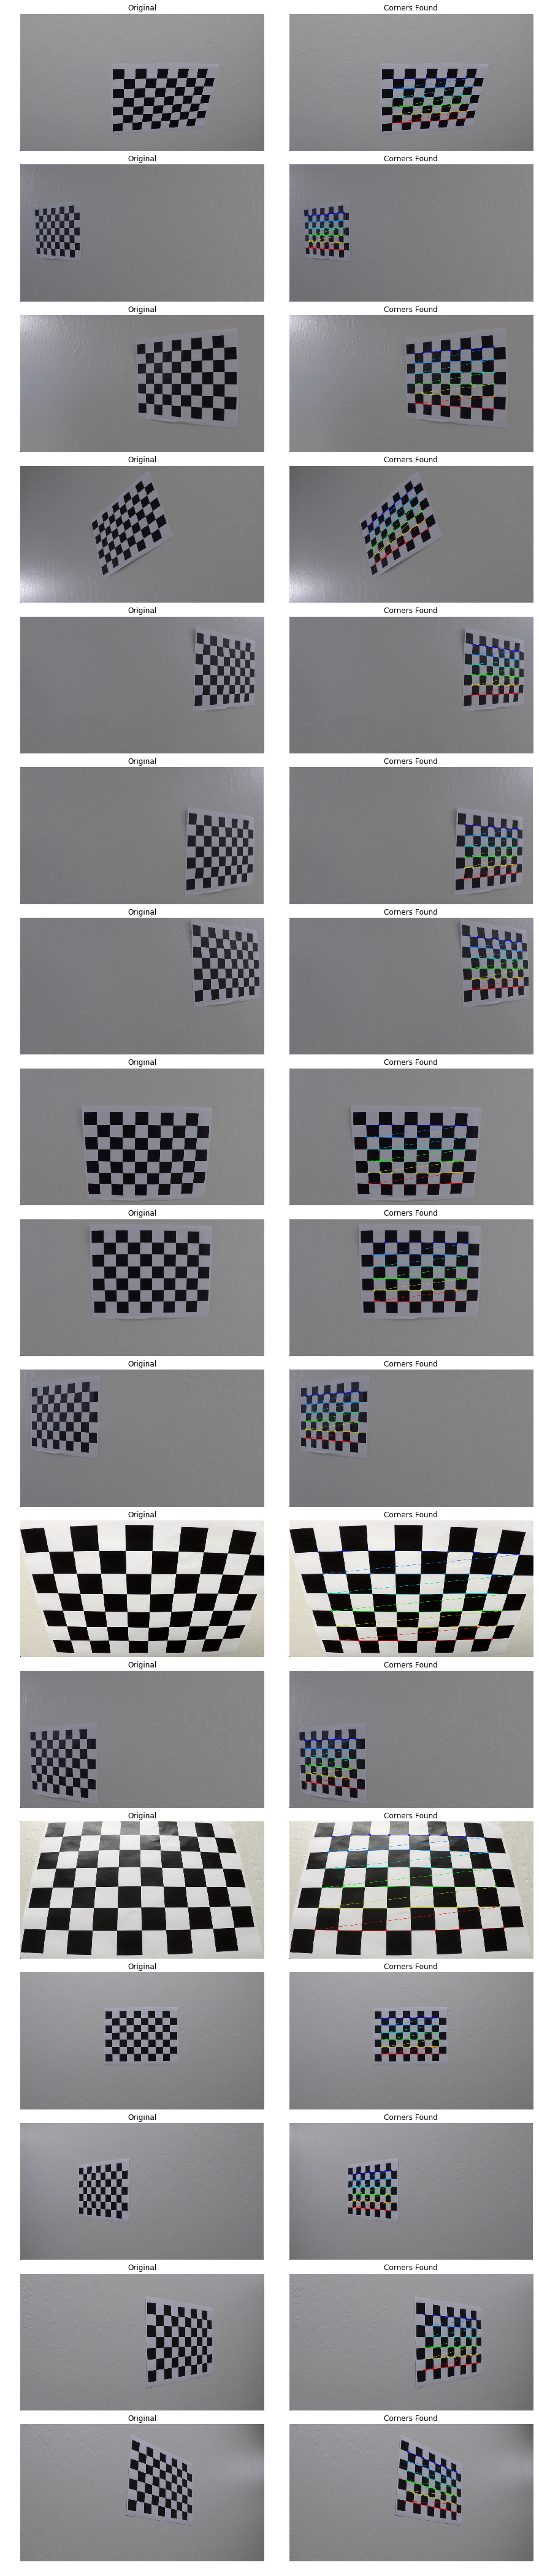

In [3]:
# import all chessboard camera calibration images using the glob package
chess_image_paths = glob.glob('./camera_cal/calibration*.jpg')

# retrieve camera calibration values using our custom camera_calibration function
chess_images, ret, mtx, dist, rvecs, tvecs = camera_calibration(chess_image_paths,plot=True)

## Undistorting images
Then using the camera matrix we calculated in the calibration phase, we're able to undistort images that were previously distorted as seen below.

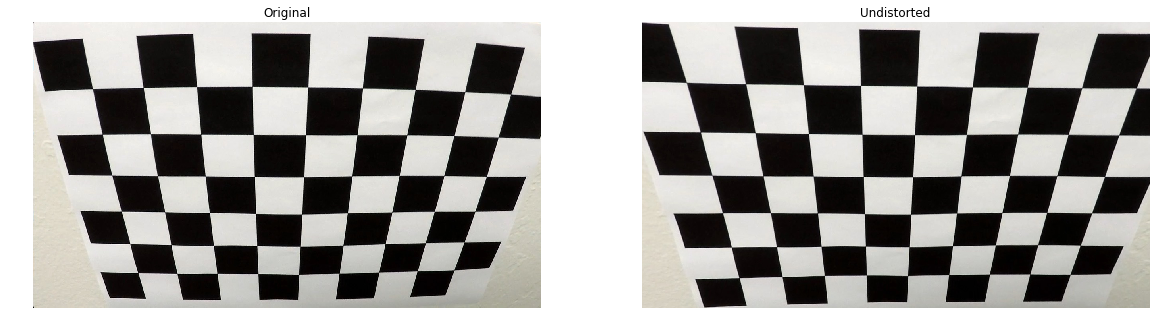

In [4]:
test_img_chess = chess_images[11] # load test image
test_img_chess_undistorted = undistort_image(test_img_chess) # undistort test image

f,(ax1,ax2) = plt.subplots(1,2,figsize=(20,30))
ax1.imshow(test_img_chess)
ax1.axis('off')
ax1.set_title('Original')
ax2.imshow(test_img_chess_undistorted)
ax2.axis('off')
ax2.set_title('Undistorted')
plt.show()

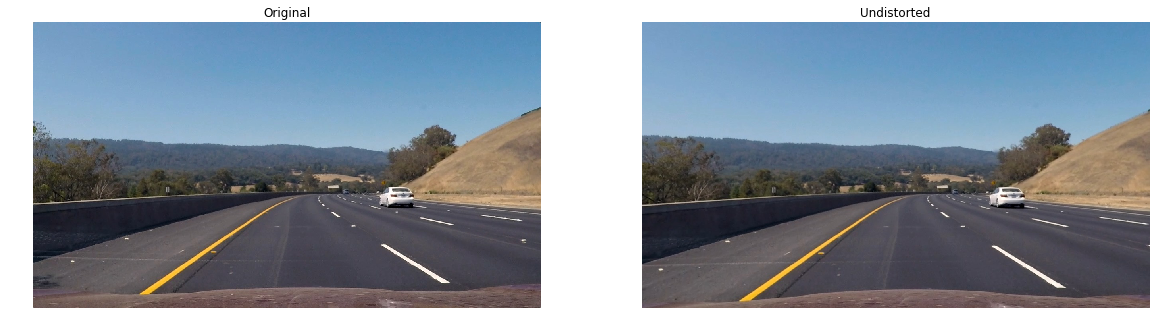

In [5]:
test_img_road = mpimg.imread('./test_images/test3.jpg') # load test image
test_img_road_undistorted = undistort_image(test_img_road) # undistort test image

f,(ax1,ax2) = plt.subplots(1,2,figsize=(20,30))
ax1.imshow(test_img_road)
ax1.axis('off')
ax1.set_title('Original')
ax2.imshow(test_img_road_undistorted)
ax2.axis('off')
ax2.set_title('Undistorted')
plt.show()

## Threshold function that returns an image filtered on gradient and color parameters
We apply an RGB to HLS conversion to our image as this simplifies the color space. This allows us to define upper and lower regions in our image that filter the white/yellow lane lines. 

In addition, we utilize sobel operators to measure the rate of change in the image. This is proves to be quite useful when mapping out the edges in an image.

In [6]:
def gradient_threshold_pipeline(img,sobel_kernel=3,blur_kernel=5,color_thresh=(0,255),mag_thresh=(0,255),dir_thresh=(0,np.pi/2)):
    # avoid writing over original image
    img = np.copy(img)
    
    # apply image blur
    # img = cv2.GaussianBlur(img,(blur_kernel,blur_kernel),0)
    
    # convert color space
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS) # converts image to HLS (hue, light, saturation) color space
    
    # white color upper and lower bounds -- we only want to bound the light channel in HLS for white
    white_lower_limit = np.array([0,210,0],dtype=np.uint8)
    white_upper_limit = np.array([255,255,255],dtype=np.uint8)
    binary_out_white = cv2.inRange(img,white_lower_limit,white_upper_limit)
    
    # yellow color upper and lower bounds -- we only want to bound the hue channel in HLS for yellow
    yellow_lower_limit = np.array([15,0,110],dtype=np.uint8)
    yellow_upper_limit = np.array([40,220,255],dtype=np.uint8)
    binary_out_yellow = cv2.inRange(img,yellow_lower_limit,yellow_upper_limit)
    
    img_s = img[:,:,2] # saves only the saturation channel
    binary_out_s = np.zeros_like(img_s)
    binary_out_s[(img_s >= 165) & (img_s <= 255)] = 1
    
    # calculating sobel (gradient) across x & y plane
    sobelx = cv2.Sobel(img_s,cv2.CV_64F,1,0,ksize=sobel_kernel)
    sobely = cv2.Sobel(img_s,cv2.CV_64F,0,1,ksize=sobel_kernel)
    
    sobelx_abs = np.absolute(sobelx)
    sobely_abs = np.absolute(sobely)
    
    sobelx_scaled = np.uint8(255*sobelx_abs/np.max(sobelx_abs))
    sobely_scaled = np.uint8(255*sobely_abs/np.max(sobely_abs))

    binary_out_x = np.zeros_like(sobelx_scaled)
    binary_out_y = np.zeros_like(sobely_scaled)
    
    binary_out_x[(sobelx_scaled >= color_thresh[0]) & (sobelx_scaled <= color_thresh[1])] = 1
    binary_out_y[(sobely_scaled >= color_thresh[0]) & (sobely_scaled <= color_thresh[1])] = 1
    
    # calculating gradient magnitude
    gradient_magnitude = np.sqrt(sobelx**2+sobely**2)
    gradient_magnitude_scaled = np.uint8(255*gradient_magnitude/np.max(gradient_magnitude))
    
    binary_out_magnitude = np.zeros_like(gradient_magnitude_scaled)
    binary_out_magnitude[(gradient_magnitude_scaled >= mag_thresh[0]) & (gradient_magnitude_scaled <= mag_thresh[1])] = 1

    # calculating gradient direction
    gradient_direction = np.arctan2(sobely_abs,sobelx_abs)

    binary_out_direction = np.zeros_like(gradient_direction)
    binary_out_direction[(gradient_direction >= dir_thresh[0]) & (gradient_direction <= dir_thresh[1])] = 1
    
    return binary_out_white,binary_out_yellow,binary_out_s,binary_out_x,binary_out_y,binary_out_magnitude,binary_out_direction

## Combine multiple thresholds to build a more reliable image
We utilize a combination of color and gradient thresholds to develop a finalized image that accurately picks up lane line information.

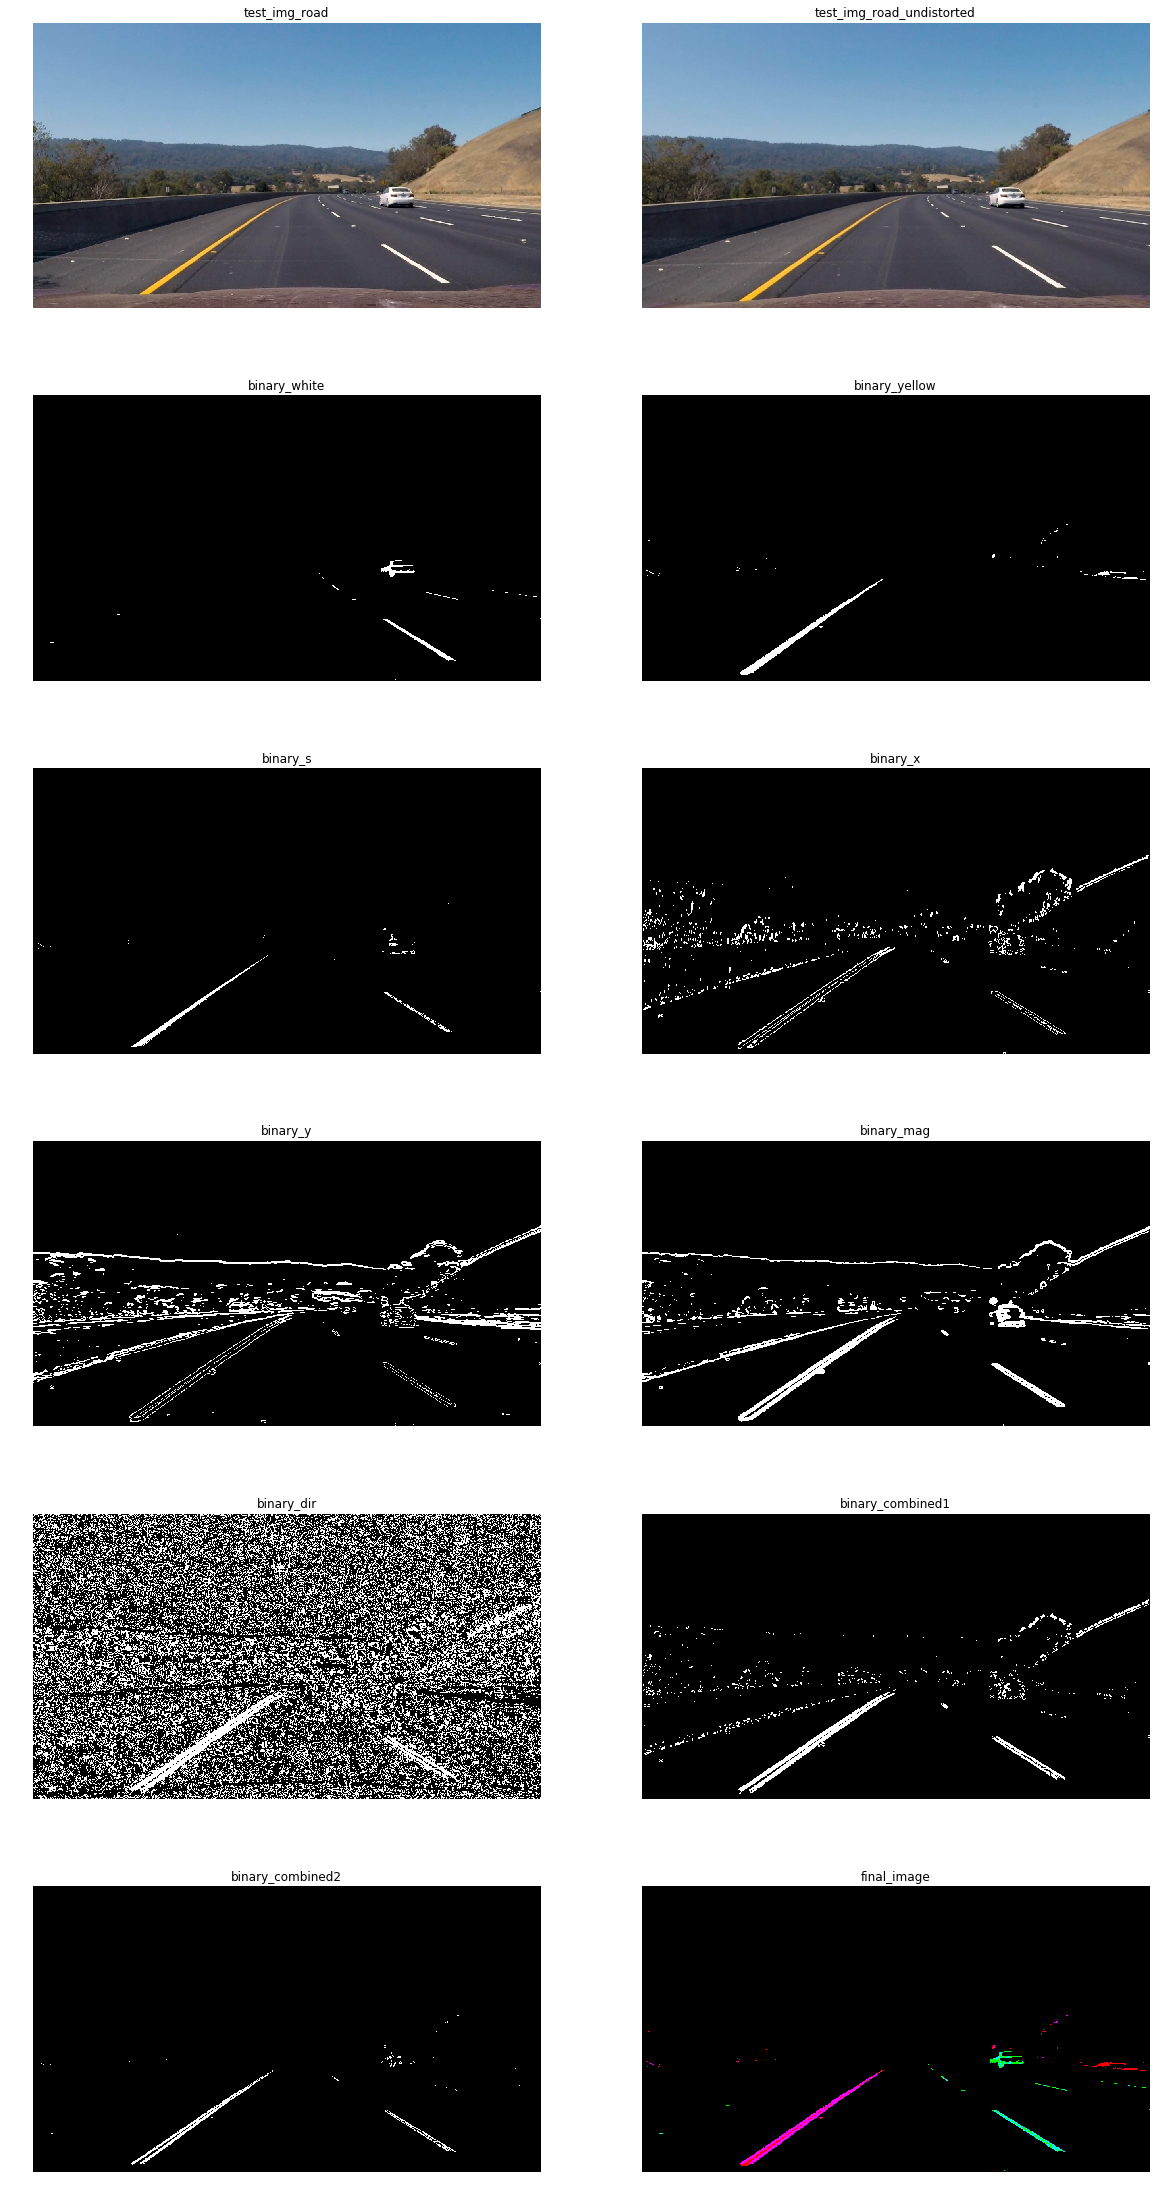

In [7]:
binary_white,binary_yellow,binary_s,binary_x,binary_y,binary_mag,binary_dir=gradient_threshold_pipeline(test_img_road_undistorted,sobel_kernel=11,color_thresh=(15,50),mag_thresh=(25,255),dir_thresh=(0.65,1.25))
binary_combined1 = np.zeros_like(binary_x)
binary_combined1[((binary_x == 1) & (binary_y == 1)) | ((binary_mag == 1) & (binary_dir == 1))] = 1
binary_combined2 = np.zeros_like(binary_x)
binary_combined2[((binary_white == 255) & (binary_combined1 == 1)) | ((binary_yellow == 255) & (binary_combined1 == 1))] = 1
final_image = np.dstack((binary_yellow,binary_white,binary_combined2*255))

binary_list = [test_img_road,test_img_road_undistorted,binary_white,binary_yellow,binary_s,binary_x,binary_y,binary_mag,binary_dir,binary_combined1,binary_combined2,final_image]
binary_list_labels = ['test_img_road','test_img_road_undistorted','binary_white','binary_yellow','binary_s','binary_x','binary_y','binary_mag','binary_dir','binary_combined1','binary_combined2','final_image']
binary_n = len(binary_list)

f,ax = plt.subplots(int(binary_n/2),2,figsize=(20,40))
i = -1
for ax_i in ax:
#     ax[i] = fig.subplots(binary_n,1,i+1)
    for j in range(len(ax_i)):
        i += 1
        try: 
            binary_list[i].shape[2]
            ax_i[j].imshow(binary_list[i])
            ax_i[j].axis('off')
            ax_i[j].set_title(binary_list_labels[i])
        except:
            try:
                ax_i[j].imshow(binary_list[i],cmap='gray')
                ax_i[j].axis('off')
                ax_i[j].set_title(binary_list_labels[i])
            except:
                pass

(-0.5, 1279.5, 719.5, -0.5)

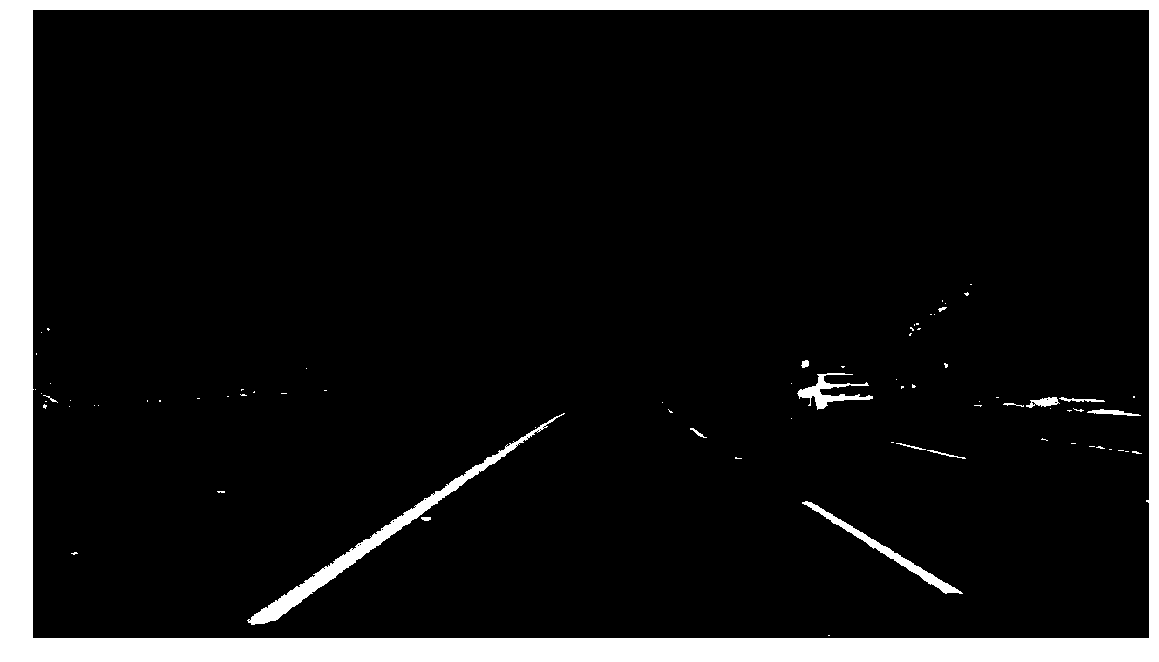

In [8]:
final_image_gray = cv2.cvtColor(final_image,cv2.COLOR_RGB2GRAY)
final_image_binary = np.zeros_like(final_image_gray)
final_image_binary[final_image_gray > 0] = 1
plt.figure(figsize=(20,20))
plt.imshow(final_image_binary,cmap='gray')
plt.axis('off')

## Plot source points on the image
In order to apply a birds-eye view perspective transform to an image, lets first plot our source points on the image.

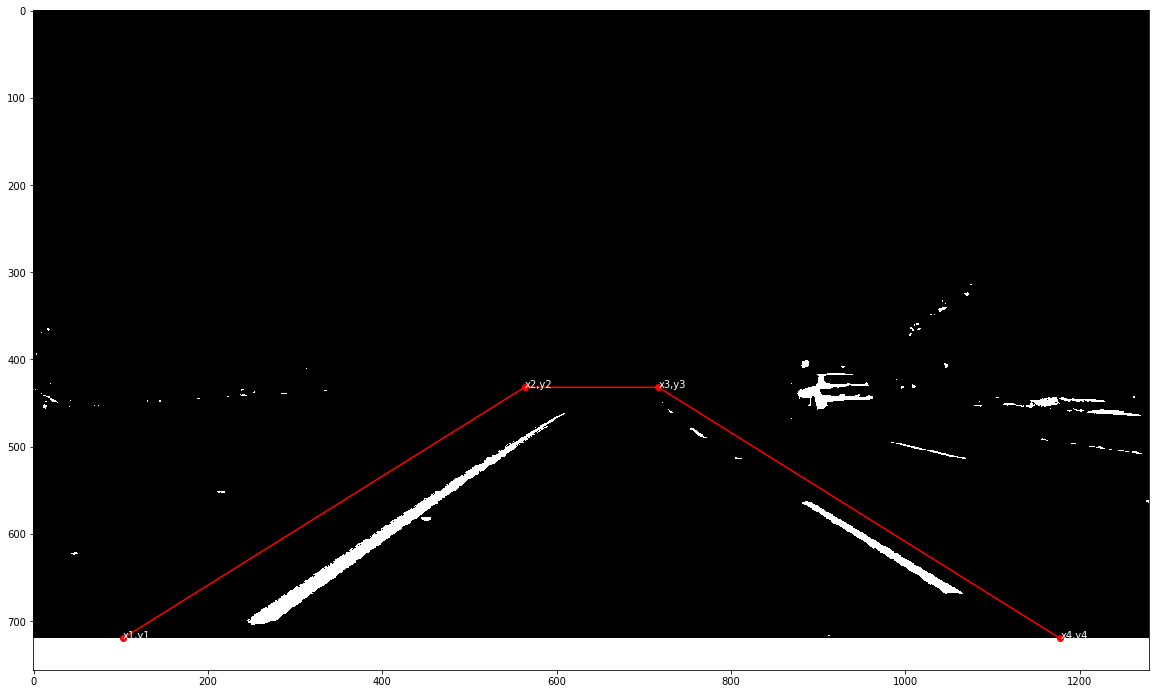

In [9]:
height = final_image_binary.shape[0]
width = final_image_binary.shape[1]
width_offset_top = 0.44
width_offset_bottom = 0.08
height_offset = 0.6
x1,y1 = width*width_offset_bottom,height
x2,y2 = width*width_offset_top,height*height_offset
x3,y3 = width*(1-width_offset_top),height*height_offset
x4,y4 = width*(1-width_offset_bottom),height
x = [x1,x2,x3,x4]
y = [y1,y2,y3,y4]
labels = ['x1,y1','x2,y2','x3,y3','x4,y4']
fig, ax = plt.subplots(figsize=(20,20))
ax.imshow(final_image_binary,cmap='gray')
# ax.axis('off')
ax.plot(x,y,'o-',color='red')

for i,label in enumerate(labels):
    ax.annotate(label,(x[i],y[i]),color='white')

## Apply birds-eye view perspective transform
Applying an accurate perspective transform to our binary image is essential to determining lane curvature later on.

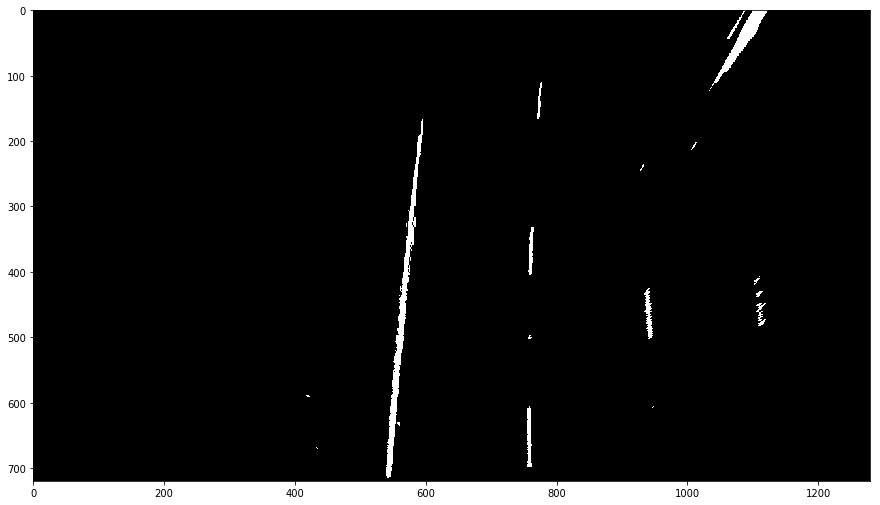

In [10]:
def region_mask(img, region):
    crop = np.zeros_like(img)
    crop_value = 255
    cv2.fillPoly(crop, region, crop_value) # sets entire cropped region to 255
    img_crop = cv2.bitwise_and(img, crop) # returns cropped img where crop values are non-zero
    return img_crop

def perspective_transform(img):
    # retrieve image dimensions
    height = final_image_binary.shape[0]
    width = final_image_binary.shape[1]
    
    # define source points
    width_offset_top = 0.44
    width_offset_bottom = 0.08
    height_offset = 0.6
    
    x1,y1 = width*width_offset_bottom,height
    x2,y2 = width*width_offset_top,height*height_offset
    x3,y3 = width*(1-width_offset_top),height*height_offset
    x4,y4 = width*(1-width_offset_bottom),height
    
    # set source points
    src = np.float32([[x1,y1],[x2,y2],[x3,y3],[x4,y4]])
    
    # define destination points
    width_offset_top = 0.3
    width_offset_bottom = 0.4
    height_offset = -1

    x1,y1 = width*width_offset_bottom,height
    x2,y2 = width*width_offset_top,height*height_offset
    x3,y3 = width*(1-width_offset_top),height*height_offset
    x4,y4 = width*(1-width_offset_bottom),height
    
    dst = np.float32([[x1,y1],[x2,y2],[x3,y3],[x4,y4]])

    M = cv2.getPerspectiveTransform(src, dst)
    M_inv = cv2.getPerspectiveTransform(dst, src)
    
    # Use cv2.warpPerspective() to warp image to a top-down view
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    unwarped = cv2.warpPerspective(warped, M_inv, (warped.shape[1],warped.shape[0]), flags=cv2.INTER_LINEAR)
    return warped,unwarped,M,M_inv

final_image_warped,final_image_unwarped,M,M_inv = perspective_transform(final_image_binary)
plt.figure(figsize=(15,15))
plt.imshow(final_image_warped,cmap='gray')

## Mask region of interest
This step masks out the noise around the lane lines.

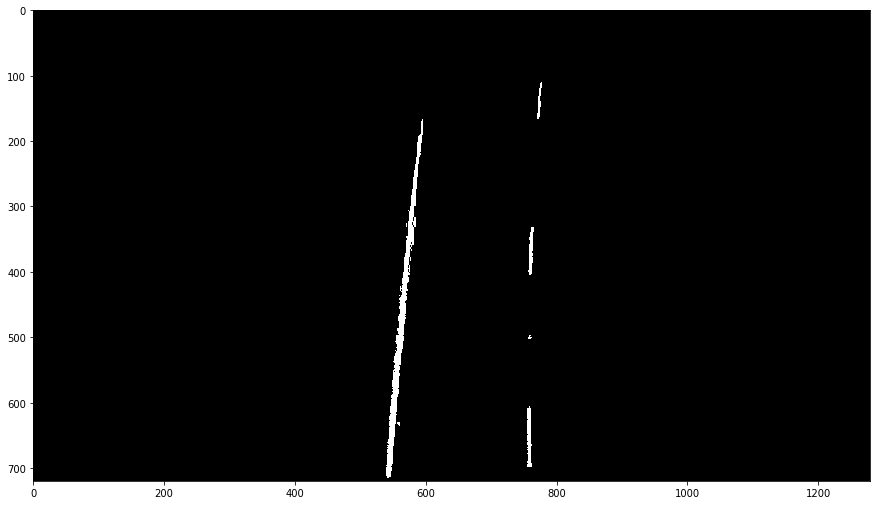

In [11]:
# define mask points
width_offset_top = 0.36
width_offset_bottom = 0.36
height_offset = 0

x1,y1 = width*width_offset_bottom,height
x2,y2 = width*width_offset_top,height*height_offset
x3,y3 = width*(1-width_offset_top),height*height_offset
x4,y4 = width*(1-width_offset_bottom),height

region = np.array([[(x1,y1),(x2,y2),(x3,y3),(x4,y4)]],dtype=np.int32)
final_image_warped_masked = region_mask(final_image_warped,region)
plt.figure(figsize=(15,15))
plt.imshow(final_image_warped_masked,cmap='gray')

## Initial lane line detection
We split the warped image into 6 parts (windows), then we use a histogram in the first window to determine the general location of the left/right lane lines. The location is determined based on where the histogram peaks are across the 1280x720 image.

Initial left lane max: 547, Initial right lane max: 759


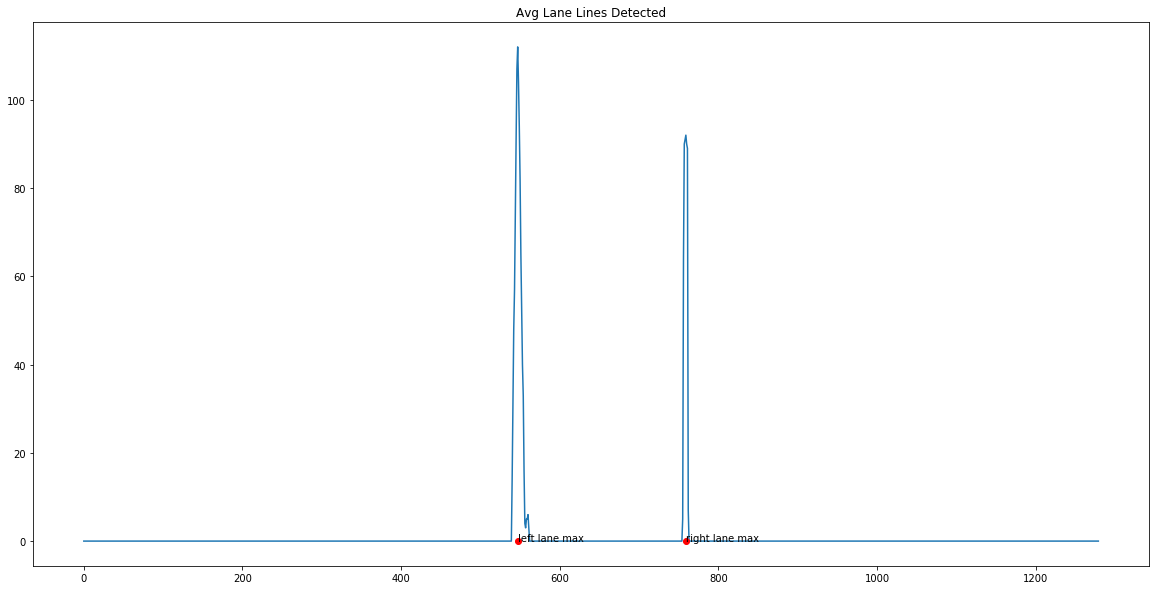

In [12]:
def initial_lane_detection(img,plot=False):
    # find the general region of where lanes are located on image
    height,width = img.shape[:2]
    hist = np.sum(final_image_warped_masked[-height//6:,:],axis=0)
    hist_midpoint = np.int(hist.shape[0]//2)
    initial_left_lane_x = np.argmax(hist[:hist_midpoint])
    initial_right_lane_x = np.argmax(hist[hist_midpoint:]) + hist_midpoint
    if plot:
        print('Initial left lane max: {}, Initial right lane max: {}'.format(initial_left_lane_x,initial_right_lane_x))
        fig,ax = plt.subplots(figsize=(20,10))
        ax.plot(hist)
        ax.set_title('Avg Lane Lines Detected')
        x = [initial_left_lane_x,initial_right_lane_x]
        y = [0,0]
        labels = ['left lane max','right lane max']
        ax.plot(x,y,'o',color='r')
        for i,label in enumerate(labels):
            ax.annotate(label,(x[i],y[i]))
    return initial_left_lane_x, initial_right_lane_x
    
initial_left_lane_x, initial_right_lane_x = initial_lane_detection(final_image_warped_masked,plot=True)

## Continuous lane line detection
Now that we know the general region of where the lanes are located, we can use this information to scan the location of the new lanes at the upcoming windows.

Using the collected (and imputed) lane line locations, we fit a line and retrieve the best fit second order polynomial values. Second order polynomial function:
![Second Order Polynomial](./media/formula_second_order_poly.png)

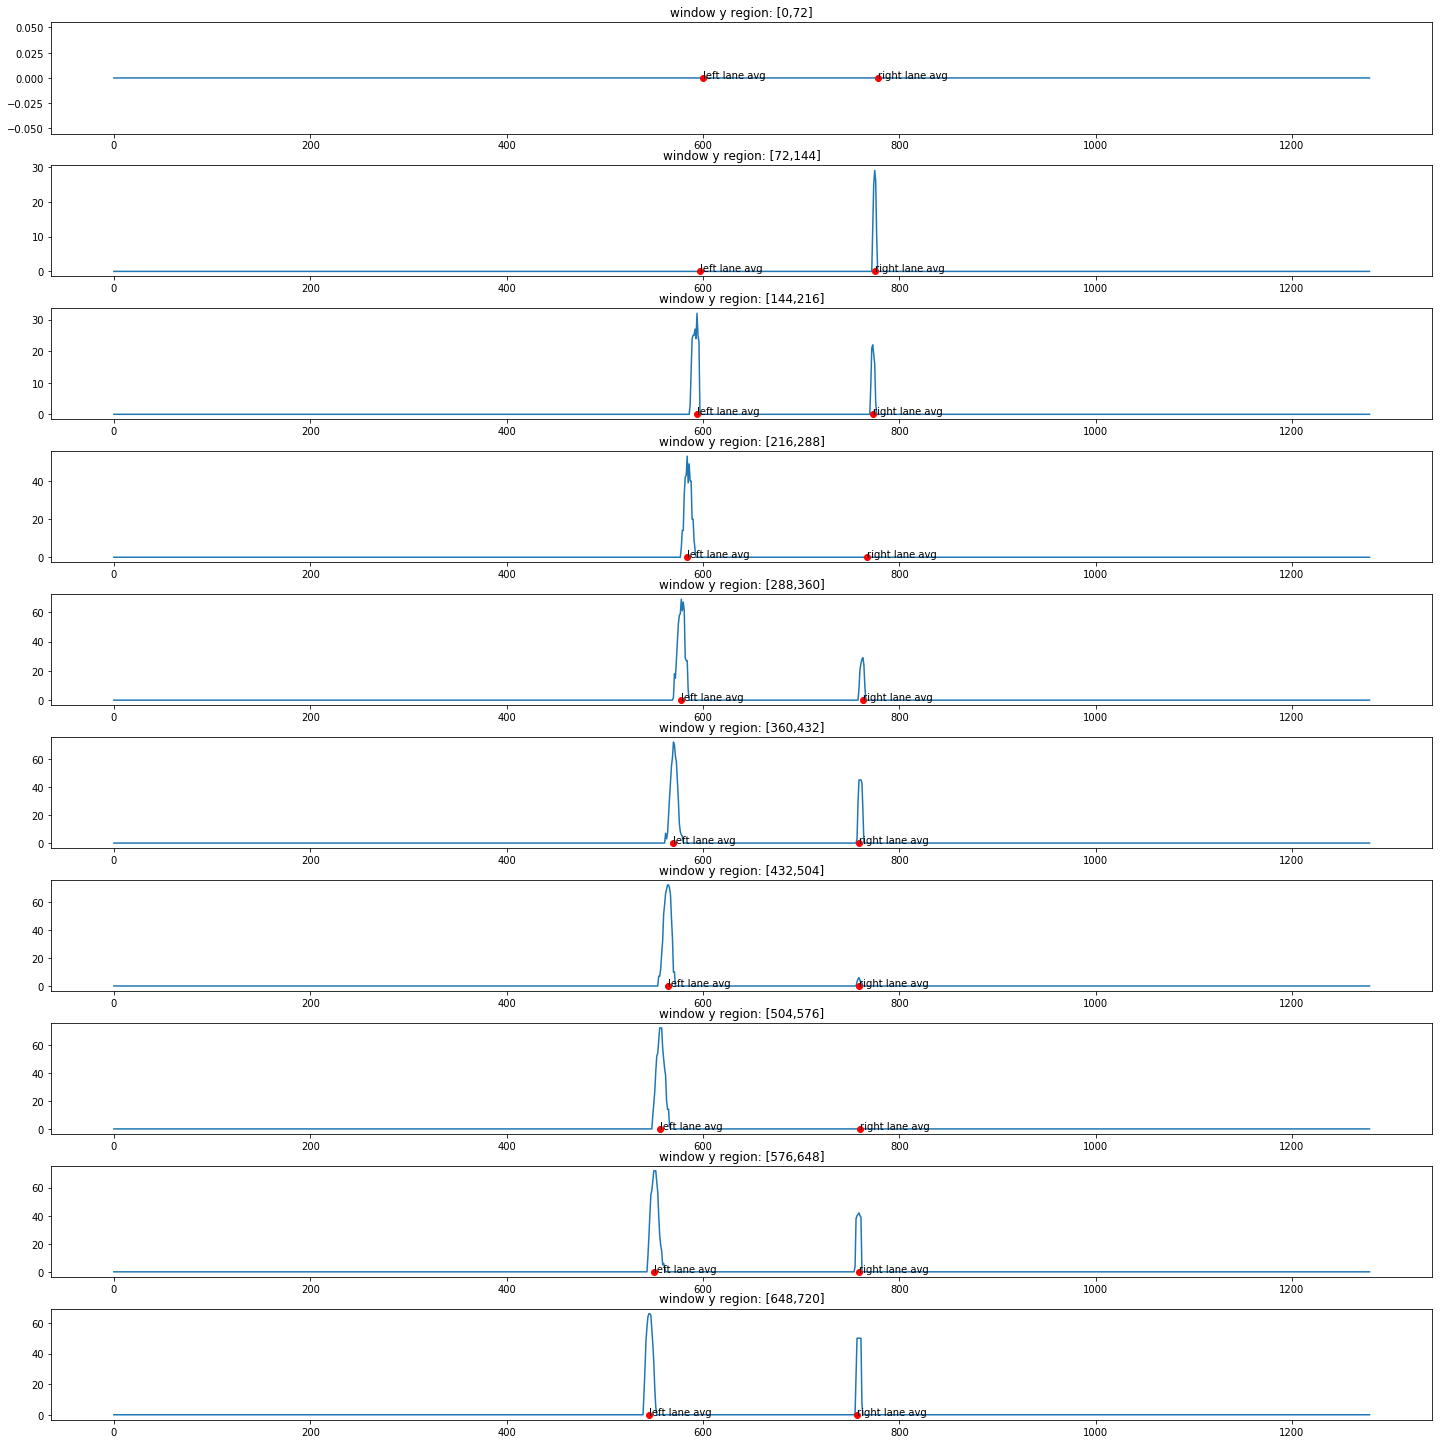

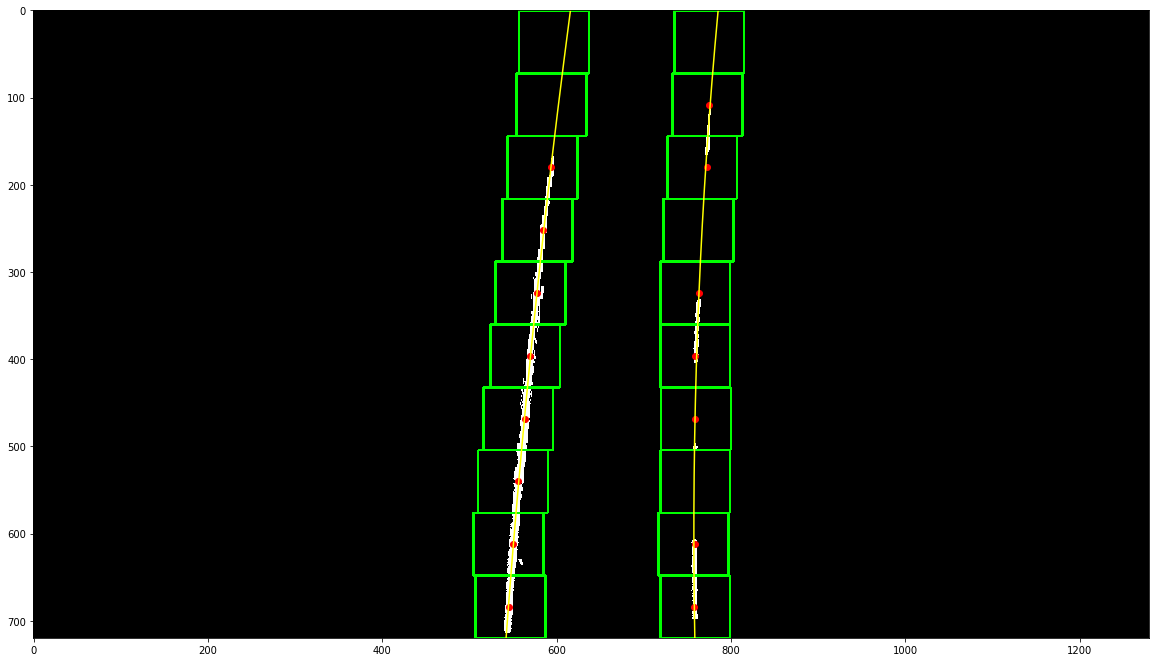

In [13]:
def continuous_lane_detection(img_warped_masked,initial_left_lane_x, initial_right_lane_x,plot=False):
    img = np.copy(img_warped_masked)
    # define lane finding parameters
    margin = 40
    empty_window_augmentation = True # when an empty window is found, aggregate lane line locations using historical data
    historical_n = 5 # number of windows we want to look back in time when calculating imputed lane locations
    window_n = 10 # number of windows we want to split the warped image

    # build final image
    img_out = np.dstack([img,img,img])*255

    # define window parameters
    height,width = img_out.shape[:2]
    window_height = height//window_n
    window_y_start = height-window_height
    window_y_end = height
    window_left_x_start = initial_left_lane_x - margin
    window_left_x_end = initial_left_lane_x + margin
    window_right_x_start = initial_right_lane_x - margin
    window_right_x_end = initial_right_lane_x + margin
    left_lane_x_list,right_lane_x_list,y_x_list = [],[],[]
    left_lane_y_list,right_lane_y_list = [],[]
    
    # initialize lane locations
    left_lane_x = initial_left_lane_x
    right_lane_x = initial_right_lane_x

    if plot:
        fig,ax = plt.subplots(window_n,1,figsize=(20,20))
        fig.tight_layout()
    
    for i in reversed(range(window_n)):
        # print('i: {}, window_y_start: {}, window_y_end: {}, window_left_x_start: {}, window_left_x_end: {}, window_right_x_start: {}, window_right_x_end: {}'.format(i,window_y_start,window_y_end,window_left_x_start,window_left_x_end,window_right_x_start,window_right_x_end))
        hist = np.sum(img[window_y_start:window_y_end,:],axis=0)
        if np.argmax(hist[np.max([window_left_x_start,0]):np.min([window_left_x_end,width])]) > 0:
            left_lane_x = np.argmax(hist[np.max([window_left_x_start,0]):np.min([window_left_x_end,width])]) + np.max([window_left_x_start,0])
            left_lane_x_list.append(left_lane_x)
            left_lane_y_list.append((window_y_end+window_y_start)/2)
        else:
            # if no points are found in argmax, we impute the lane locations using recent data
            lane_range_list = list(reversed(range(1,historical_n+1)))
            for lane_range in lane_range_list:
                # retrieve most recent lane avg points for left lane and compute average
                if len(left_lane_x_list) == 0:
                    left_lane_x = initial_left_lane_x
                    left_lane_y = (window_y_end+window_y_start)/2
                    left_lane_x_list.append(left_lane_x)
                    left_lane_y_list.append(left_lane_y)
                    break
                elif len(left_lane_x_list) >= lane_range:
                    recent_delta = int(sum([(left_lane_x_list[-i]-left_lane_x_list[-(i+1)]) for i in range(1,lane_range,2)])/lane_range)
                    left_lane_x += recent_delta
                    break

        if np.argmax(hist[np.max([window_right_x_start,0]):np.min([window_right_x_end,width])]) > 0:
            right_lane_x = np.argmax(hist[np.max([window_right_x_start,0]):np.min([window_right_x_end,width])]) + np.max([window_right_x_start,0])
            right_lane_x_list.append(right_lane_x)
            right_lane_y_list.append((window_y_end+window_y_start)/2)
        else:
            # if no points are found in argmax, we impute the lane locations using recent data
            lane_range_list = list(reversed(range(1,historical_n+1)))
            for lane_range in lane_range_list:
                # retrieve most recent lane avg points for right lane and compute average
                if len(right_lane_x_list) == 0:
                    right_lane_x = initial_right_lane_x
                    right_lane_y = (window_y_end+window_y_start)/2
                    right_lane_x_list.append(right_lane_x)
                    right_lane_y_list.append(right_lane_y)
                    break
                elif len(right_lane_x_list) >= lane_range:
                    recent_delta = int(sum([(right_lane_x_list[-i]-right_lane_x_list[-(i+1)]) for i in range(1,lane_range,2)])/lane_range)
                    right_lane_x += recent_delta

        y_x_list.append((window_y_end+window_y_start)/2)

        if plot:
            ax[i].plot(hist)
            ax[i].set_title('window y region: ['+str(window_y_start)+','+str(window_y_end)+']')
            x = [left_lane_x,right_lane_x]
            y = [0,0]
            labels = ['left lane avg','right lane avg']
            ax[i].plot(x,y,'o',color='r')
            for j,label in enumerate(labels):
                ax[i].annotate(label,(x[j],y[j]))

        # draw window scan region
        cv2.rectangle(img_out,(window_left_x_start,window_y_start),(window_left_x_end,window_y_end),[0,255,0],2)
        cv2.rectangle(img_out,(window_right_x_start,window_y_start),(window_right_x_end,window_y_end),[0,255,0],2)

        # update next window scan region
        window_left_x_start = left_lane_x - margin
        window_left_x_end = left_lane_x + margin
        window_right_x_start = right_lane_x - margin
        window_right_x_end = right_lane_x + margin
        window_y_start -= window_height
        window_y_end -= window_height

    y_plot = np.linspace(0,height-1,height)
    left_lane_fit = np.polyfit(left_lane_y_list,left_lane_x_list,2) # finds best fit
    left_lane_fit_x = left_lane_fit[0]*y_plot**2 + left_lane_fit[1]*y_plot + left_lane_fit[2] # determines x values in respect to the y_plot
    right_lane_fit = np.polyfit(right_lane_y_list,right_lane_x_list,2) # finds best fit
    right_lane_fit_x = right_lane_fit[0]*y_plot**2 + right_lane_fit[1]*y_plot + right_lane_fit[2] # determines x values in respect to the y_plot
    if plot:
        plt.figure(figsize=(20,20))
        plt.imshow(img_out)
        plt.plot(left_lane_x_list,left_lane_y_list,'o',color='r')
        plt.plot(right_lane_x_list,right_lane_y_list,'o',color='r')
        plt.plot(left_lane_fit_x,y_plot,'-',color='yellow')
        plt.plot(right_lane_fit_x,y_plot,'-',color='yellow')
    
    return img_out,left_lane_fit,right_lane_fit,left_lane_fit_x,right_lane_fit_x,left_lane_x_list,right_lane_x_list,left_lane_y_list,right_lane_y_list,y_plot

img_out,left_lane_fit,right_lane_fit,left_lane_fit_x,right_lane_fit_x,left_lane_x_list,right_lane_x_list,left_lane_y_list,right_lane_y_list,y_plot = continuous_lane_detection(final_image_warped_masked,initial_left_lane_x,initial_right_lane_x,plot=True)

## Calculating radius of curvature
1. In order to calculate the radius of curvature, we first need to find the 1st and 2nd derivatives of our second order polynomial function:
![second_order_poly](./media/formula_second_order_poly.png)
![derivatives](./media/formula_12derivatives.png)

2. We convert our pixel scale into real world coordinates using an appropriate meter to pixel ratio:
![Pixel Conversion](./media/formula_pixel_conversion.png)

3. After calculating their respective derivatives, we estimate the radius of curvature for both left/right lane lines using our curvature formula:
![R-Curve1](./media/formula_rcurve1.png)

In [54]:
def curve_and_offset(left_lane_x_list,right_lane_x_list,left_lane_y_list,right_lane_y_list):
#     img_out = np.copy(img)
    mid_x = 1280//2
    mpp_y = 30/720 # meters per pixel y
    mpp_x = 3.7/(right_lane_x_list[0]-left_lane_x_list[0]) # meters per pixel x
    y_value = np.max(y_plot)
#     quadratic_coeff = 3e-4
#     leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) for y in ploty])
#     rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) for y in ploty])
    
    left_lane_y = np.array(left_lane_y_list)
    left_lane_x = np.array(left_lane_x_list)
    left_lane_fit = np.polyfit(left_lane_y*mpp_y,left_lane_x*mpp_x,2) # finds best fit
#     left_lane_fit = np.polyfit(left_lane_y,left_lane_x,2) # finds best fit

    right_lane_y = np.array(right_lane_y_list)
    right_lane_x = np.array(right_lane_x_list)
    right_lane_fit = np.polyfit(right_lane_y*mpp_y,right_lane_x*mpp_x,2) # finds best fit
#     right_lane_fit = np.polyfit(right_lane_y,right_lane_x,2) # finds best fit
    
    center_offset = ((left_lane_x[0] + right_lane_x[0])/2 - mid_x) * mpp_x
    
    r_curve_left = ((1+(2*left_lane_fit[0]*y_value*mpp_y+left_lane_fit[1])**2)**1.5)/np.absolute(2*left_lane_fit[0])
    r_curve_right = ((1+(2*right_lane_fit[0]*y_value*mpp_y+right_lane_fit[1])**2)**1.5)/np.absolute(2*right_lane_fit[0])
    
    r_curve_left_value = np.average(r_curve_left) # curve average
    r_curve_right_value = np.average(r_curve_right) # curve average
    return r_curve_left,r_curve_right,left_lane_fit,right_lane_fit,center_offset

r_curve_left,r_curve_right,left_lane_fit,right_lane_fit,center_offset = curve_and_offset(left_lane_x_list,right_lane_x_list,left_lane_y_list,right_lane_y_list)
r_curve_left,r_curve_right,left_lane_fit,right_lane_fit,center_offset

(1239.3892112856295,
 642.43518083112042,
 array([  4.04000699e-04,  -5.50595238e-02,   1.07477489e+01]),
 array([  7.78358743e-04,  -3.88873383e-02,   1.37041766e+01]),
 0.19198113207547168)

## Plot lane mask and text info to image

(-0.5, 1279.5, 719.5, -0.5)

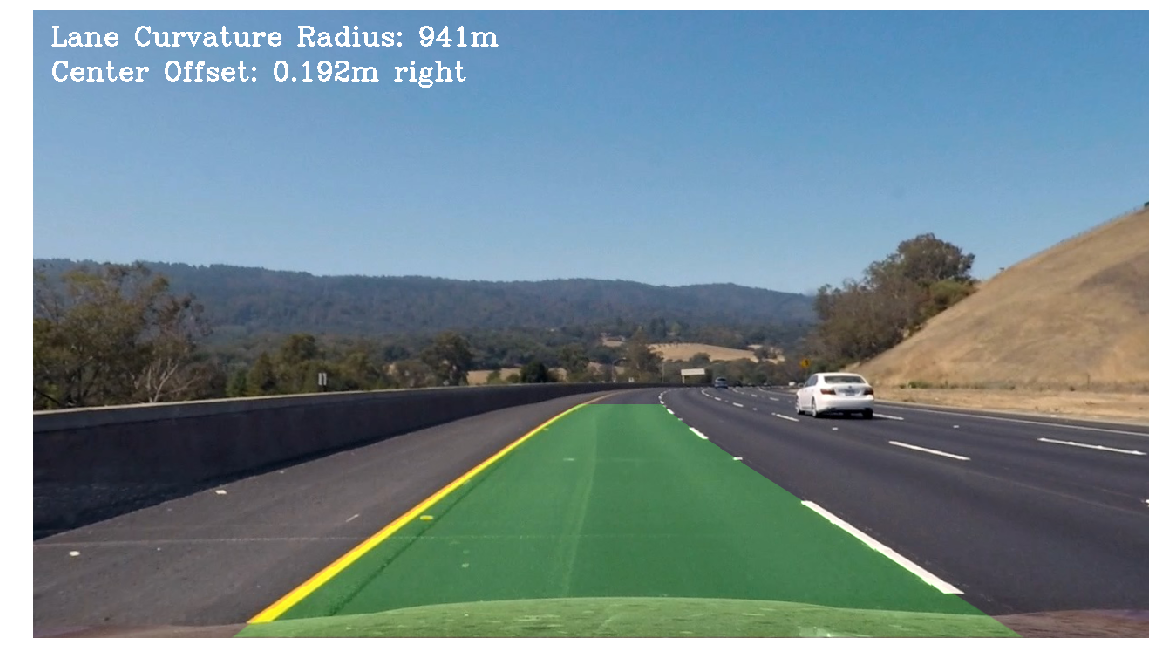

In [50]:
def plot_lane_mask(img_undistorted,img_warp,r_curve_left,r_curve_right,left_lane_fit_x,right_lane_fit_x,center_offset,y_plot):
#     mpp_x = 1/1280 # meters per pixel x
#     mpp_y = 30/720 # meters per pixel y
#     mpp_x = 3.7/200 # meters per pixel x
#     y_value = np.max(y_plot) # center offset is evaluated at this y location (towards the bottom of image)
    
    img_undistorted_out = np.copy(img_undistorted)
    img_warp_out = np.copy(img_warp)
    
    zero_binary = np.zeros_like(img_warp_out).astype(np.uint8)
    zero_rgb = np.dstack((zero_binary,zero_binary,zero_binary))

    left_lane_pts = np.array([np.transpose(np.vstack([left_lane_fit_x,y_plot]))])
    right_lane_pts = np.array([np.flipud(np.transpose(np.vstack([right_lane_fit_x,y_plot])))])
    lane_pts = np.hstack((left_lane_pts,right_lane_pts))

    # plot mask
    image_shape = (img_undistorted_out.shape[1],img_undistorted_out.shape[0])
    cv2.fillPoly(zero_rgb,np.int_([lane_pts]), (0,255,0))
    lane_overlay = cv2.warpPerspective(zero_rgb,M_inv,image_shape)

#     height,width = img_undistorted_out.shape[:2]
#     mid_x = width//2
    
#     left_lane_x = left_lane_fit[0]*y_value**2 + left_lane_fit[1]*y_value + left_lane_fit[2]
#     right_lane_x = right_lane_fit[0]*y_value**2 + right_lane_fit[1]*y_value + right_lane_fit[2]
    
#     center_position = ((left_lane_pts[0,0,0]+right_lane_pts[0,0,0])/2 - mid_x) * mpp_x
#     center_offset = ((left_lane_x + right_lane_x)/2 - mid_x) * mpp_x
    if center_offset > 0:
        direction = 'right'
    else:
        direction = 'left'

    r_curve_avg = (r_curve_left + r_curve_right)/2
    final_out = cv2.addWeighted(img_undistorted,1,lane_overlay,0.22,0)
    cv2.putText(final_out,'Lane Curvature Radius: {:.0f}m'.format(r_curve_avg),(20,40),cv2.FONT_HERSHEY_COMPLEX,1,(255,255,255),2)
    cv2.putText(final_out,'Center Offset: {:.3f}m {}'.format(np.abs(center_offset),direction),(20,80),cv2.FONT_HERSHEY_COMPLEX,1,(255,255,255),2)
    return final_out

final_out = plot_lane_mask(test_img_road_undistorted,final_image_warped_masked,r_curve_left,r_curve_right,left_lane_fit_x,right_lane_fit_x,center_offset,y_plot)
plt.figure(figsize=(20,20))
plt.imshow(final_out)
plt.axis('off')

## Define line class and processing pipeline
We define a line class that stores vital information as we process lane lines in a video. Our processing pipeline brings together all the functions and processing steps we outlined above.

In [16]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False
        # tracks lane curvature
        self.recent_r_curve = []
        # keeps track of initial x location when line was discovered
        self.initial_loc = None
        # recent polynomial coefficients
        self.recent_fit = []
        # polynomial coefficients averaged over the last n iterations
        self.best_fit = None
        # polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        # difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        # x values for detected line pixels
        self.allx = None  
        # y values for detected line pixels
        self.ally = None
        # counter to reset if issues persist after 5 iterations
        self.count = 0

In [49]:
def main_pipeline(img):
    # retrieve image dimensions
    height,width = img.shape[:2]
    
    # undistorted image
    img_undistorted = undistort_image(img)
    
    # apply color and gradient threshold
    binary_white,binary_yellow,binary_s,binary_x,binary_y,binary_mag,binary_dir=gradient_threshold_pipeline(img_undistorted,sobel_kernel=11,color_thresh=(15,50),mag_thresh=(25,255),dir_thresh=(0.65,1.25))
    binary_combined1 = np.zeros_like(binary_x)
    binary_combined1[((binary_x == 1) & (binary_y == 1)) | ((binary_mag == 1) & (binary_dir == 1))] = 1
    binary_combined2 = np.zeros_like(binary_x)
    binary_combined2[((binary_white == 255) & (binary_combined1 == 1)) | ((binary_yellow == 255) & (binary_combined1 == 1))] = 1
    
    # finalized image is a combination of yellow/white color threshold, and a mixture of x,y, magnitude, and direction gradient
    final_image = np.dstack((binary_yellow,binary_white,binary_combined2*255))
    final_image_gray = cv2.cvtColor(final_image,cv2.COLOR_RGB2GRAY)
    final_image_binary = np.zeros_like(final_image_gray)
    final_image_binary[final_image_gray > 0] = 1
    
    # apply perspective transform to binary image to get a birds eye view of road
    final_image_warped,final_image_unwarped,M,M_inv = perspective_transform(final_image_binary)

    # define mask points and apply mask
    width_offset_top = 0.36
    width_offset_bottom = 0.36
    height_offset = 0
    x1,y1 = width*width_offset_bottom,height
    x2,y2 = width*width_offset_top,height*height_offset
    x3,y3 = width*(1-width_offset_top),height*height_offset
    x4,y4 = width*(1-width_offset_bottom),height
    region = np.array([[(x1,y1),(x2,y2),(x3,y3),(x4,y4)]],dtype=np.int32)
    final_image_warped_masked = region_mask(final_image_warped,region)
    
    # find the general region of where lanes are located on image
    if left_line.detected == False | right_line.detected == False:
        # print('first time detecting')
        initial_left_lane_x, initial_right_lane_x = initial_lane_detection(final_image_warped_masked)
        left_line.initial_x = initial_left_lane_x
        right_line.initial_x = initial_right_lane_x
        left_line.detected = True
        right_line.detected = True
        
    img_out,left_lane_fit,right_lane_fit,left_lane_fit_x,right_lane_fit_x,left_lane_x_list,right_lane_x_list,left_lane_y_list,right_lane_y_list,y_plot = continuous_lane_detection(final_image_warped_masked,left_line.initial_x,right_line.initial_x)
    
    try:
        n = 5
        left_line.current_fit = left_lane_fit # finds best fit
        left_line.all_x = left_lane_x_list
        left_line.all_y = left_lane_y_list
        left_line.recent_fit.append(left_line.current_fit)
        if len(left_line.recent_fit) > 1:
            left_line.diffs = (left_line.recent_fit[-2] - left_line.recent_fit[-1]) / left_line.recent_fit[-2]
        left_line.recent_fit = left_line.recent_fit[-n:]
        left_line.best_fit = np.mean(left_line.recent_fit, axis = 0)
        left_fit = left_line.current_fit
        left_line.detected = True
        left_line.count = 0
    except TypeError:
        left_fit = left_line.best_fit
        left_line.detected = False
    except np.linalg.LinAlgError:
        left_fit = left_line.best_fit
        left_line.detected = False
    
    try:
        n = 5
        right_line.current_fit = right_lane_fit # finds best fit
        right_line.all_x = right_lane_x_list
        right_line.all_y = right_lane_y_list
        right_line.recent_fit.append(right_line.current_fit)
        if len(right_line.recent_fit) > 1:
            right_line.diffs = (right_line.recent_fit[-2] - right_line.recent_fit[-1]) / right_line.recent_fit[-2]
        right_line.recent_fit = right_line.recent_fit[-n:]
        right_line.best_fit = np.mean(right_line.recent_fit, axis = 0)
        right_fit = right_line.current_fit
        right_line.detected = True
        right_line.counter = 0
    except TypeError:
        right_fit = right_line.best_fit
        right_line.detected = False
    except np.linalg.LinAlgError:
        right_fit = right_line.best_fit
        right_line.detected = False
    
    # left/right curvature is calculated
    r_curve_left,r_curve_right,center_offset = curve_and_offset(left_lane_x_list,right_lane_x_list,left_lane_y_list,right_lane_y_list)

    left_line.recent_r_curve.append(r_curve_left)
    right_line.recent_r_curve.append(r_curve_right)

    max_r_curve_data = 30
    if len(left_line.recent_r_curve) > max_r_curve_data:
        left_line.recent_r_curve = left_line.recent_r_curve[-max_r_curve_data:]
        right_line.recent_r_curve = right_line.recent_r_curve[-max_r_curve_data:]
    
    if len(left_line.recent_r_curve) > 1:
        weights = np.linspace(0,1,len(left_line.recent_r_curve))/(len(left_line.recent_r_curve)/2)
        left_r_curve_avg = np.average(left_line.recent_r_curve,weights=weights)
        right_r_curve_avg = np.average(right_line.recent_r_curve,weights=weights)
    else:
        left_r_curve_avg = np.average(left_line.recent_r_curve)
        right_r_curve_avg = np.average(right_line.recent_r_curve)
    
    # plot lane mask and text
    final_out = plot_lane_mask(img_undistorted,final_image_warped_masked,r_curve_left,r_curve_right,left_lane_fit_x,right_lane_fit_x,center_offset,y_plot)
    return final_out

## Process test video using our pipeline
Finally, we test our advanced lane finding pipeline by processing a sample video.

In [18]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

left_line = Line()
right_line = Line()

# Pipeline.set_values(line, M, Minv, cameraMat, distCoeffs)

# import all chessboard camera calibration images using the glob package
chess_image_paths = glob.glob('./camera_cal/calibration*.jpg')

# retrieve camera calibration values using our custom camera_calibration function
chess_images, ret, mtx, dist, rvecs, tvecs = camera_calibration(chess_image_paths)

output_video_title = 'project_video_out.mp4'
clip1 = VideoFileClip('project_video.mp4')
output_video = clip1.fl_image(main_pipeline)
%time output_video.write_videofile(output_video_title, audio=False)

# video_clip.reader.close()
# video_clip.audio.reader.close_proc()

ModuleNotFoundError: No module named 'moviepy'

## Model Performance
As we can see, our pipeline appears to handle lane lines quite well. (Note: Click on the image to watch the full video on youtube).

<a href='https://www.youtube.com/watch?v=W-C7Ia23fD8'>![Test](project_video_out.gif)</a>

## Future Work
1. The model performed just OK on the challenge video but poorly on the harder challenge due to vastly different lighting and road conditions. I'd like to revist them when time permits.
2. I'd like to incorporate more redundancy checks in the model. For example, in the event that there's shadows in an image that disrupt the identification of the left lane line while the right lane line remains unaffected, I'd like the model to piggy-back on the right lane line when estimating the curvature of the left lane line.
3. It might be interesting to see how well this model can perform on other roads and conditions. 
4. Developing a smoothing system that uses recent historical lane line data would further enhance the models ability to detect lane lines and mitigate the outliers that may arise in some road conditions.